In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from multitask_sparse_parity import generate_multitask_sparse_parity_dataset
from sgld_utils import (
    SGLDConfig, 
    run_sgld
)
from utils import to_json_friendly_tree, running_mean
import jax
import jax.numpy as jnp
from typing import Sequence, Callable, Dict, Tuple, Optional
import optax
import numpy as np


def data_generator(
    features: jnp.ndarray,
    labels: jnp.ndarray,
    batch_size: int,
    key: jax.random.PRNGKey, 
):
    dataset_size = len(features)
    indices = jnp.arange(dataset_size)
    
    while True:
        key, subkey = jax.random.split(key)
        permuted_indices = jax.random.permutation(subkey, indices)
        
        for start in range(0, dataset_size, batch_size):
            end = min(start + batch_size, dataset_size)
            batch_indices = permuted_indices[start:end]
            yield features[batch_indices], labels[batch_indices]



In [2]:
import haiku as hk

class MLP(hk.Module):
    def __init__(
        self,
        hidden_sizes: Sequence[int],
        out_size: int,
        activation: Callable = jax.nn.relu
    ):
        super().__init__()
        self.hidden_sizes = hidden_sizes
        self.out_size = out_size
        self.activation = activation

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        for hidden_size in self.hidden_sizes:
            x = hk.Linear(hidden_size)(x)
            x = self.activation(x)
        return hk.Linear(self.out_size)(x)

def create_model(
    hidden_sizes: Sequence[int],
    out_size: int
) -> hk.Transformed:
    def _model_fn(x):
        model = MLP(hidden_sizes, out_size)
        return model(x)
    
    return hk.transform(_model_fn)


In [3]:
# config
rngseed = 0
rngkey = jax.random.PRNGKey(rngseed)

dataset_seed = 0

n_tasks, n, k = 30, 50, 3
num_train_samples = 100000
num_test_samples = 20000
alpha = 0.5

hidden_sizes = [1024, 1024]
batch_size = 256
num_steps = 30001
learning_rate = 1e-3

sgld_config = {
    'epsilon': 5e-6,
    'gamma': 1.0,
    'num_steps': 1000,
    "num_chains": 1, 
    "batch_size": 256
}
sgld_config = SGLDConfig(**sgld_config)
loss_trace_minibatch = True
burn_in_prop = 0.9
itemp = 1.0 / jnp.log(num_train_samples)



do_llc_estimation = True
logging_period = 500

# Generate dataset
rng_key = jax.random.PRNGKey(rngseed)
data_key, model_key, split_key, gen_key = jax.random.split(rng_key, 4)
num_total_samples = num_train_samples + num_test_samples

features, labels, subtasks = generate_multitask_sparse_parity_dataset(
    data_key,
    n_tasks,
    n,
    k,
    num_total_samples, 
    alpha=alpha
)
labels = jax.nn.one_hot(labels, 2)
print(labels.shape)


# Split into train and test sets
indices = jnp.arange(num_total_samples)
train_indices = jax.random.choice(split_key, indices, shape=(num_train_samples,), replace=False)
test_indices = jnp.setdiff1d(indices, train_indices)

train_features, train_labels = features[train_indices], labels[train_indices]
test_features, test_labels = features[test_indices], labels[test_indices]

# Create model
input_size = n_tasks + n
output_size = 2
model = create_model(hidden_sizes, output_size)
param_init = model.init(model_key, jnp.zeros((input_size,)))

num_parameters = sum(np.prod(p.shape) for p in jax.tree_util.tree_flatten(param_init)[0])
print(f"Number of parameters: {num_parameters}")

# Training setup
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(param_init)

@jax.jit
def loss_fn(
    params: hk.Params,
    x: jnp.ndarray,
    y: jnp.ndarray
) -> jnp.ndarray:
    # pred = jax.vmap(model.apply, in_axes=(None, None, 0))(params, None, x)
    logits = model.apply(params, None, x)
    return jnp.mean(optax.sigmoid_binary_cross_entropy(logits, y))

@jax.jit
def make_step(
    params: hk.Params,
    x: jnp.ndarray,
    y: jnp.ndarray,
    opt_state,
):
    loss, grads = jax.value_and_grad(loss_fn)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

@jax.jit
def compute_accuracy(
    params: hk.Params,
    x: jnp.ndarray,
    y: jnp.ndarray
) -> float:
    logits = model.apply(params, None, x)
    # logits = jax.vmap(model.apply, in_axes=(None, None, 0))(params, None, x)
    preds = jax.nn.sigmoid(logits) > 0.5
    return jnp.mean(preds == y)


def compute_task_losses(
    params: hk.Params,
    features: jnp.ndarray,
    labels: jnp.ndarray,
    n_tasks: int
) -> Tuple[Dict[int, float], Dict[int, float]]:
    task_losses = {}
    task_errors = {}
    
    for task_idx in range(n_tasks):
        task_mask = features[:, task_idx] == 1
        task_features = features[task_mask]
        task_labels = labels[task_mask]
        loss = loss_fn(params, task_features, task_labels)
        error = 1 - compute_accuracy(params, task_features, task_labels)
        task_losses[task_idx] = float(loss)
        task_errors[task_idx] = float(error)
    return task_losses, task_errors


# Create data generator
train_gen = data_generator(train_features, train_labels, batch_size, gen_key)

# Training loop
records = []
param = param_init
step = 0

(120000, 2)
Number of parameters: 1134594


In [4]:
extra_steps = 70000
while step < num_steps + extra_steps:
    x_batch, y_batch = next(train_gen)
    loss, param, opt_state = make_step(param, x_batch, y_batch, opt_state)
    
    if step % logging_period == 0:
        test_acc = compute_accuracy(param, test_features, test_labels)
        test_loss = loss_fn(param, test_features, test_labels)
        batch_acc = compute_accuracy(param, x_batch, y_batch)
        
        # Compute task-wise test losses
        task_losses, task_errors = compute_task_losses(param, test_features, test_labels, n_tasks)
        rec = {
            "step": step,
            "loss": float(loss),
            "test_loss": float(test_loss),
            "test_acc": float(test_acc),
            "batch_acc": float(batch_acc),
            "task_losses": task_losses,
            "task_errors": task_errors
        }

        # do_llc_estimation
        if do_llc_estimation:
            x_train = train_features
            y = jax.nn.softmax(model.apply(param, None, x_train))

            rngkey, subkey = jax.random.split(rngkey)
            loss_trace, distances, acceptance_probs = run_sgld(
                subkey, 
                loss_fn, 
                sgld_config, 
                param, 
                x_train, 
                y,
                itemp=itemp, 
                trace_batch_loss=loss_trace_minibatch, 
                compute_distance=False, 
                verbose=False, 
                compute_mala_acceptance=False
            )
            trace_start = min(int(burn_in_prop * len(loss_trace)), len(loss_trace) - 1)
            init_loss = loss_fn(param, x_train, y)
            lambdahat = float(np.mean(loss_trace[trace_start:]) - init_loss) * num_train_samples * itemp
            rec.update(
                {
                    "llc_est": float(lambdahat),
                    # "loss_trace": loss_trace, 
                    # "init_loss": float(init_loss),
                }
            )
        print(
            f"Step {step:6d}, Loss: {loss:.7f}, Test Acc: {test_acc:.7f}"
            + f", llc_est: {lambdahat:.2f}" if do_llc_estimation else ""
        )
        
        records.append(rec)
    step += 1
    if step >= num_steps:
        break


Step      0, Loss: 0.6977938, Test Acc: 0.5009750, llc_est: -119.24
Step    500, Loss: 0.4164763, Test Acc: 0.7195750, llc_est: 38.94
Step   1000, Loss: 0.3908729, Test Acc: 0.7189750, llc_est: 183.53
Step   1500, Loss: 0.4009581, Test Acc: 0.7471000, llc_est: 138.81
Step   2000, Loss: 0.2467692, Test Acc: 0.7869000, llc_est: 267.72
Step   2500, Loss: 0.2599897, Test Acc: 0.8109500, llc_est: 349.00
Step   3000, Loss: 0.2439438, Test Acc: 0.8224750, llc_est: 436.55
Step   3500, Loss: 0.1700359, Test Acc: 0.8392750, llc_est: 578.89
Step   4000, Loss: 0.1254333, Test Acc: 0.8511500, llc_est: 653.81
Step   4500, Loss: 0.1217834, Test Acc: 0.8577250, llc_est: 714.27
Step   5000, Loss: 0.1013526, Test Acc: 0.8594500, llc_est: 836.34
Step   5500, Loss: 0.0647791, Test Acc: 0.8636250, llc_est: 945.28
Step   6000, Loss: 0.0484216, Test Acc: 0.8642750, llc_est: 968.70
Step   6500, Loss: 0.0566024, Test Acc: 0.8677250, llc_est: 1073.92
Step   7000, Loss: 0.0244878, Test Acc: 0.8679750, llc_est: 1

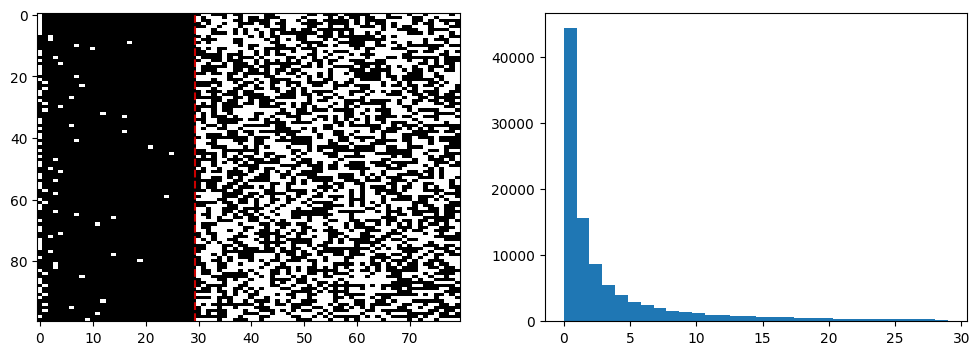

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
ax.imshow(train_features[:100], aspect="auto", cmap="gray");
ymin, ymax = ax.get_ylim()
ax.vlines(n_tasks - 0.6, ymin, ymax, color="r", linestyle="--", alpha=0.8)

ax = axes[1]
ax.hist(jnp.argmax(train_features[:, :n_tasks], axis=1), bins=n_tasks);


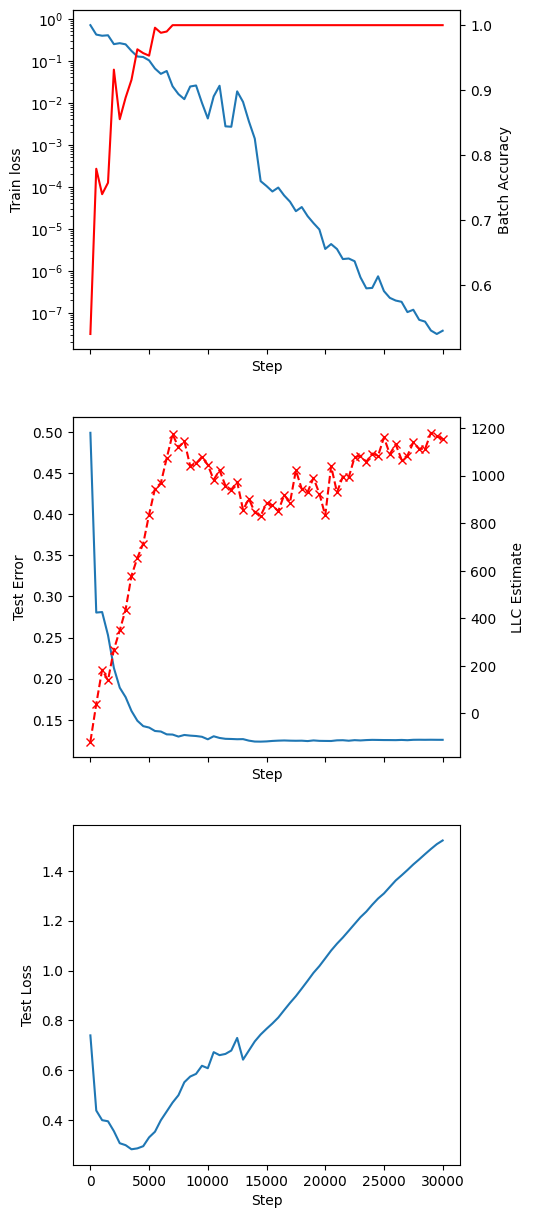

In [6]:
df_rec = pd.DataFrame(records)
df = df_rec.copy(deep=True)
# df = df[df["step"] < 10**4]

fig, axes = plt.subplots(3, 1, figsize=(5, 15), sharex=True)
ax = axes[0]
ax.plot(df["step"], df["loss"])
ax.set_ylabel("Train loss")
ax.set_yscale("log")
# ax.set_xscale("log")

ax = ax.twinx()
ax.plot(df["step"], df["batch_acc"], label="Batch Acc", color="r")

ax.set_ylabel("Batch Accuracy")


ax = axes[1]
ax.plot(df["step"], 1 - df["test_acc"], label="Test Error")
# ax.set_ylim(df_rec["test_acc"].min(), 1)
ax.set_ylabel("Test Error")
# ax.set_yscale("log")
# ax.set_xscale("log")
if do_llc_estimation:
    ax = ax.twinx()
    ax.plot(df["step"], df["llc_est"], "rx--", label="llc_est")
    ax.set_ylabel("LLC Estimate")



ax = axes[2]
ax.plot(df["step"], df["test_loss"], label="Test Loss")
ax.set_ylabel("Test Loss")
# ax.set_yscale("log")
# ax.set_xscale("log")



for ax in axes:
    ax.set_xlabel("Step")
    # ax.set_yscale("log")
    # ax.set_xscale("log")


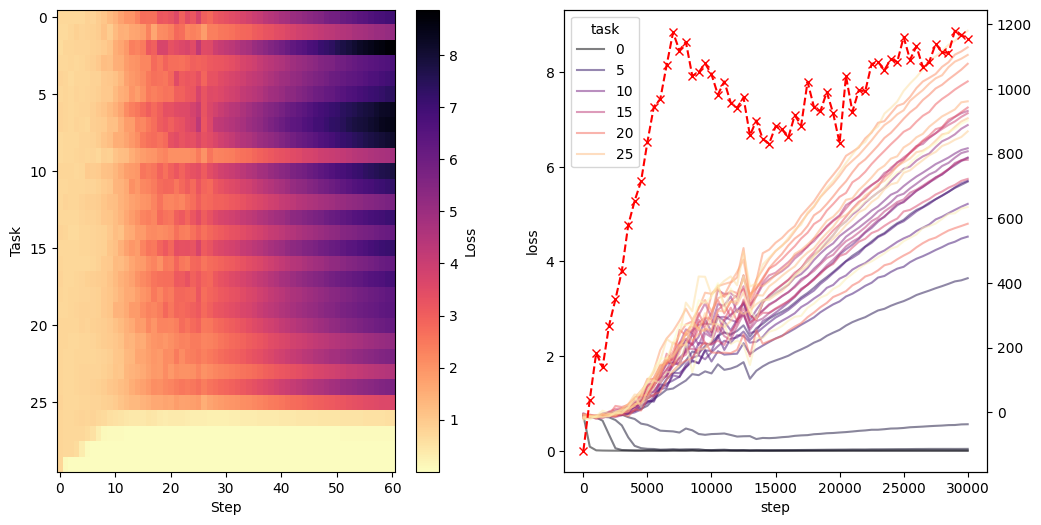

In [7]:
task_losses = df["task_losses"].apply(pd.Series)
task_losses = task_losses.loc[:, sorted(task_losses.columns, reverse=True)]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]
cax = ax.imshow(task_losses.transpose(), aspect="auto", cmap="magma_r")
ax.set_xlabel("Step")
ax.set_ylabel("Task")
fig.colorbar(cax, ax=ax, label="Loss")

ax = axes[1]
task_losses["step"] = df["step"]
task_losses = task_losses.melt(id_vars="step", var_name="task", value_name="loss")
sns.lineplot(data=task_losses, x="step", y="loss", hue="task", ax=ax, palette="magma", alpha=0.5)
# ax.set_yscale("log")

if do_llc_estimation:
    ax = ax.twinx()
    ax.plot(df["step"], df["llc_est"], "rx--", label="llc_est")


<Axes: xlabel='step', ylabel='error'>

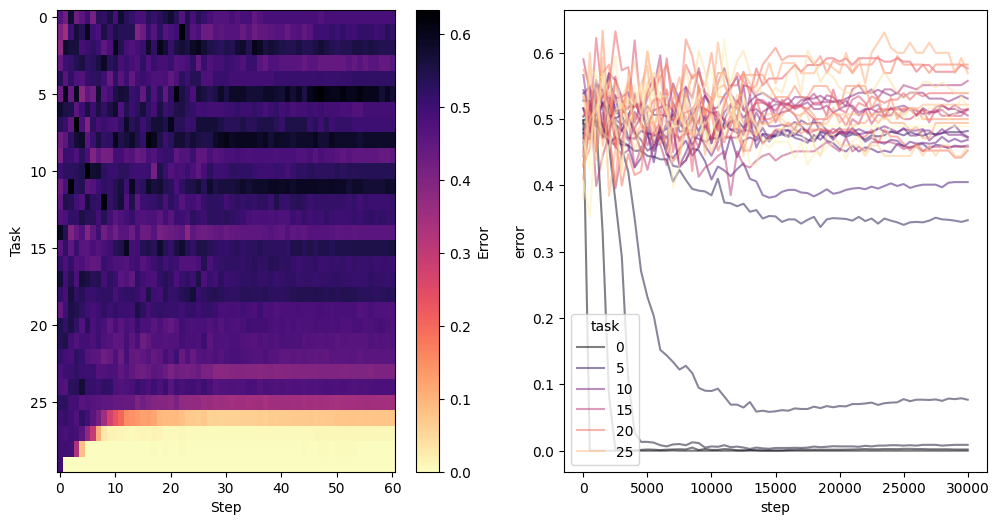

In [8]:
task_errors = df["task_errors"].apply(pd.Series)
task_errors = task_errors.loc[:, sorted(task_errors.columns, reverse=True)]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]
cax = ax.imshow(task_errors.transpose(), aspect="auto", cmap="magma_r")
ax.set_xlabel("Step")
ax.set_ylabel("Task")
fig.colorbar(cax, ax=ax, label="Error")
# ax.set_xscale("log")

ax = axes[1]
task_errors["step"] = df["step"]
task_errors = task_errors.melt(id_vars="step", var_name="task", value_name="error")
sns.lineplot(data=task_errors, x="step", y="error", hue="task", ax=ax, palette="magma", alpha=0.5)

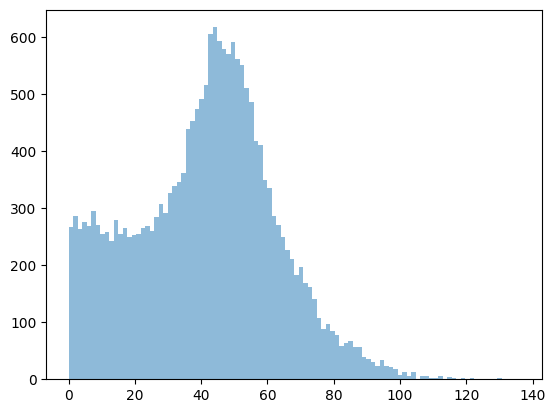

In [9]:
# plt.hist(jax.vmap(model)(test_features).squeeze(), bins=100, alpha=0.5, label="Predictions");
plt.hist(np.linalg.norm(model.apply(param, None, test_features).squeeze(), axis=-1), bins=100, alpha=0.5, label="Predictions");

# Task-wise training

In [10]:
early_stopping_epsilon = 1e-8
num_stages = 15

param_stage = param_init
optimizer_stage = optax.adam(learning_rate)
opt_state_stage = optimizer_stage.init(param_stage)

stage_records = []
for stage in range(1, num_stages):
    task_ids = np.arange(stage).astype(int)
    stage_mask = (train_features[:, task_ids[0]] == 1)
    
    for task_id in task_ids[1:]:
        stage_mask = stage_mask | (train_features[:, task_id] == 1)
    stage_features = train_features[stage_mask]
    stage_labels = train_labels[stage_mask]
    print(stage_features.shape, stage_labels.shape)


    # Create data generator
    rng_key, gen_key = jax.random.split(rng_key)
    train_gen_stage = data_generator(stage_features, stage_labels, batch_size, gen_key)

    # Training loop
    stage_rec = []
    step_stage = 0
    while step_stage < num_steps:
        x_batch, y_batch = next(train_gen_stage)
        loss, param_stage, opt_state_stage = make_step(param_stage, x_batch, y_batch, opt_state_stage)

        if step_stage % logging_period == 0:
            test_acc = compute_accuracy(param_stage, test_features, test_labels)
            test_loss = loss_fn(param_stage, test_features, test_labels)
            batch_acc = compute_accuracy(param_stage, x_batch, y_batch)
            rec = {
                "step": step_stage,
                "loss": float(loss),
                "test_loss": float(test_loss),
                "test_acc": float(test_acc),
                "batch_acc": float(batch_acc),
            }
            
            stage_rec.append(rec)
            if do_llc_estimation:
                x_train = stage_features
                y = jax.nn.softmax(model.apply(param_stage, None, x_train))

                rngkey, subkey = jax.random.split(rngkey)
                loss_trace, distances, acceptance_probs = run_sgld(
                    subkey, 
                    loss_fn, 
                    sgld_config, 
                    param_stage, 
                    x_train, 
                    y,
                    itemp=itemp, 
                    trace_batch_loss=loss_trace_minibatch, 
                    compute_distance=False, 
                    verbose=False, 
                    compute_mala_acceptance=False
                )
                trace_start = min(int(burn_in_prop * len(loss_trace)), len(loss_trace) - 1)
                init_loss = loss_fn(param_stage, x_train, y)
                lambdahat = float(np.mean(loss_trace[trace_start:]) - init_loss) * num_train_samples * itemp
                rec.update(
                    {
                        "llc_est": float(lambdahat),
                        # "loss_trace": loss_trace, 
                        # "init_loss": float(init_loss),
                    }
                )
            print(
                f"Stage {stage}, "
                + f"Step {step_stage:6d}, "
                + f"Loss: {loss:.8f}, "
                + f"Test Acc: {test_acc:.2f}, "
                + f"llc_est: {lambdahat:.2f}" if do_llc_estimation else ""
            )
        step_stage += 1
        if step_stage >= num_steps:
            break    
        if step_stage > 0 and stage_rec[-1]["loss"] < early_stopping_epsilon:
            break
    stage_records.append(stage_rec)

    

(44432, 80) (44432, 2)
Stage 1, Step      0, Loss: 0.68981993, Test Acc: 0.50, llc_est: 211.79
Stage 1, Step    500, Loss: 0.00029963, Test Acc: 0.72, llc_est: 63.44
Stage 1, Step   1000, Loss: 0.00004810, Test Acc: 0.72, llc_est: 31.92
Stage 1, Step   1500, Loss: 0.00001784, Test Acc: 0.72, llc_est: 21.61
Stage 1, Step   2000, Loss: 0.00000762, Test Acc: 0.72, llc_est: 21.57
Stage 1, Step   2500, Loss: 0.00000480, Test Acc: 0.72, llc_est: 7.62
Stage 1, Step   3000, Loss: 0.00000275, Test Acc: 0.72, llc_est: 5.56
Stage 1, Step   3500, Loss: 0.00000201, Test Acc: 0.72, llc_est: 6.28
Stage 1, Step   4000, Loss: 0.00000125, Test Acc: 0.72, llc_est: 8.33
Stage 1, Step   4500, Loss: 0.00000083, Test Acc: 0.72, llc_est: 5.32
Stage 1, Step   5000, Loss: 0.00000050, Test Acc: 0.72, llc_est: 3.25
Stage 1, Step   5500, Loss: 0.00000040, Test Acc: 0.72, llc_est: 4.12
Stage 1, Step   6000, Loss: 0.00000025, Test Acc: 0.72, llc_est: 7.43
Stage 1, Step   6500, Loss: 0.00000021, Test Acc: 0.72, llc_e

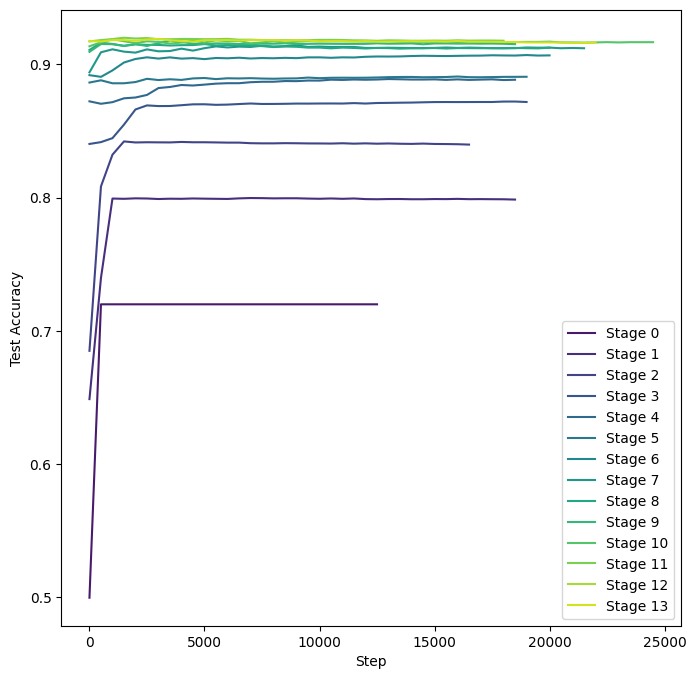

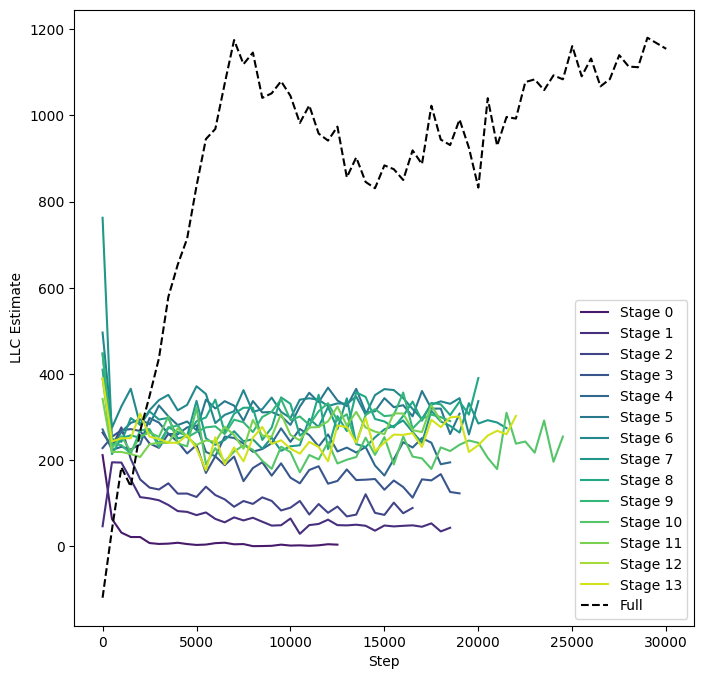

In [17]:
num_to_plot = len(stage_records)
with sns.color_palette("viridis", n_colors=num_to_plot):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for stage, stage_rec in enumerate(stage_records[:num_to_plot]):
        df_stage = pd.DataFrame(stage_rec)
        ax.plot(df_stage["step"], df_stage["test_acc"], label=f"Stage {stage}")
    ax.legend()
    ax.set_xlabel("Step")
    ax.set_ylabel("Test Accuracy")

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for stage, stage_rec in enumerate(stage_records[:num_to_plot]):
        df_stage = pd.DataFrame(stage_rec)
        ax.plot(df_stage["step"], df_stage["llc_est"], label=f"Stage {stage}")
    ax.plot(df["step"], df["llc_est"], "k--", label="Full")
    ax.legend()
    ax.set_xlabel("Step")
    ax.set_ylabel("LLC Estimate")
    

# LLC and dLLC

Text(0, 0.5, 'LLC Estimate')

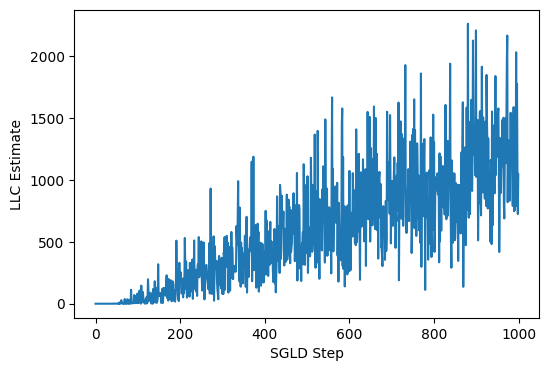

In [12]:
sgld_config = {
    'epsilon': 5e-6,
    'gamma': 1.0,
    'num_steps': 1000,
    "num_chains": 1, 
    "batch_size": 512
}
sgld_config = SGLDConfig(**sgld_config)

rngkey = jax.random.PRNGKey(0)
rngkey, subkey = jax.random.split(rngkey)
x_train = train_features
y = model.apply(param, None, x_train)
y = jax.nn.softmax(y)
itemp = 1.0 / np.log(num_train_samples)
loss_trace, _, _ = run_sgld(
    subkey, 
    loss_fn, 
    sgld_config, 
    param, 
    x_train, 
    y,
    itemp=itemp, 
    compute_mala_acceptance=False,
    compute_distance=False,
)
loss_trace = np.array(loss_trace)
llc_trace = (loss_trace - loss_trace[0]) * num_train_samples * itemp
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(llc_trace)
ax.set_xlabel("SGLD Step")
ax.set_ylabel("LLC Estimate")